# Which is the best method for detecting data drift on large datasets?

**TL;DR:** We compared five different statistical tests for drift detection on large datasets. Our goal was to build intuition on how the tests react to data changes of varying magnitude. We also share the code so you can run the experiments on your data.

## Too much data, too much drift

Each statistical test has particular properties and in-built assumptions.

Let's take a two-sample [Kolmogorov-Smirnov (KS) test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test). It is often a default choice for detecting a distributional change in numerical features. While it does the job in many cases, the test can be "too sensitive" for larger datasets. It would fire alarms for many real-world use cases all the time, just because you have a lot of data and small changes add up. You need to account for such test behavior when picking your drift metric.

## Experiment Design

We picked five popular statistical tests and metrics for detecting data drift. Then, we tested how they work on artificially shifted features and a few real datasets.

Here is the list of statistical tests we've played with:
- Kolmogorov-Smirnov test
- Population Stability Index (PSI)
- Wasserstein distance test (Earth-Mover Distance)
- Kullback-Leibler divergence
- Jensen-Shannon distance

First, we chose three features with different characteristics:

- Feature 1: A continuous feature with non-normal distribution. For convenience, let's call it the "Multimodal feature."
- Feature 2: A variable with a heavy right tail. We'll call it the "Right-tailed feature."
- Feature 3: Hereafter referred to as "Feature with outliers."


In [8]:
from typing import Tuple
import pandas as pd
import numpy as np 
from scipy import stats
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt

In [7]:
RED = '#ed0400'
GREY = '#4d4d4d'
PALETTE=['#0a5f38', '#6c3461', '#ab1239']

/home/bruno/miniconda3/envs/bru_ds/lib/python3.8/site-packages/sklearn/datasets/_openml.py:65: RuntimeWarning: Invalid cache, redownloading file
  warn("Invalid cache, redownloading file", RuntimeWarning)


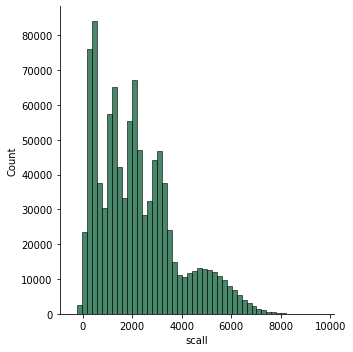

In [3]:
from sklearn.datasets import fetch_openml

data = fetch_openml(name='BNG(cpu_small)', version=1)
df = data.frame
feature_1 = df.scall
sns.displot(feature_1, bins=50, color='#0a5f38');

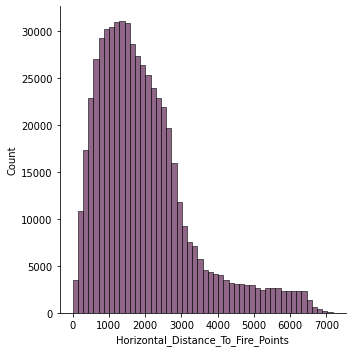

In [4]:
from sklearn import datasets
data = datasets.fetch_covtype()
df = pd.DataFrame(data['data'], columns=data['feature_names'])
feature_2 = df.Horizontal_Distance_To_Fire_Points
sns.displot(feature_2, bins=50, color='#6c3461');

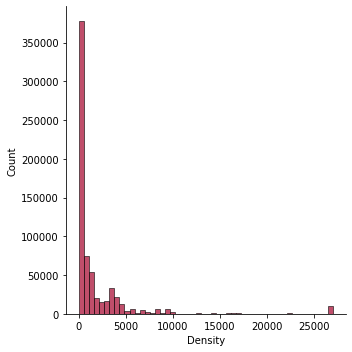

In [5]:
data = fetch_openml(name='French-Motor-Claims-Datasets-freMTPL2freq', version=1)
df = data.frame
feature_3 = df.Density
sns.displot(feature_3, bins=50,  color='#ab1239');

**Then, we implemented a function to imitate data drift.** 

We wanted to introduce an artificial change that would resemble real-world drift. To do that, we decided to shift the whole distribution for each feature by a fixed value. Here is the formula we used to create drift:

$$(\alpha + mean(feature)) * perc$$

By using the mean value of each feature, we ensured that:

1. the shift was relative to the feature value range,
2. it was possible to compare how tests behave for different features with a specific "drift size."

In [6]:
del df, data

In [7]:
feature_1.shape, feature_2.shape, feature_3.shape

((1000000,), (581012,), (678013,))

In [8]:
feature_list = [feature_1, feature_2, feature_3]
feature_names = ['Multimodal feature', 'Right-tailed feature', 'Feature with outliers']

In [9]:
from evidently.analyzers.stattests.jensenshannon import jensenshannon_stat_test
from evidently.analyzers.stattests.kl_div import kl_div_stat_test
from evidently.analyzers.stattests.ks_stattest import ks_stat_test
from evidently.analyzers.stattests.psi import psi_stat_test
from evidently.analyzers.stattests.wasserstein_distance_norm import wasserstein_stat_test

In this experiment, we again artificially shifted the feature distribution in the current group. We sequentially applied different changes to imitate small or large drifts, shifting data by 1%, 5%, 7%, 10%, and 20%. We applied this change to the whole dataset.

We fixed the sample size and compared samples with 100,000 observations. We talk about large datasets, after all!

For each combination, we applied our chosen drift tests. The goal was to evaluate how sensitive the test is to the "size of drift."

In [10]:
def split_data(s: pd.Series, size: int, split_ratio: int=1) -> Tuple[pd.Series, pd.Series]:
  """Sample two groups from the real data.
  Args:
    s: data we sample from
    size: size of the current group
    split_ratio: size of the reference group = ratio * size of the current group
  Returns:
    ref, curr: reference and current groups
    """
  ref = pd.Series(np.random.choice(s, size=size * split_ratio))
  curr = pd.Series(np.random.choice(s, size=size))
  return ref, curr

def add_drift(curr: pd.Series, drift_size: float, drift_ratio: float, drift_mode: str='fixed') -> pd.Series:
  """Artificially adds a shift to the data.
  Args:
    curr: initial data
    drift_size: percents initial values would be increased by
    drift_ratio: defines what percent of data would be drifted
    drift_mode:
      if drift_mode == 'fixed': 
        # here we should use mean(reference), but in out experiment mean(reference) = mean(current) at this stage
        all values moved by fixed delta = (alpha + mean(feature)) * drift_size
      elif: 
        drift_mode == 'relative': vlues moved by delta(value) = value * drift_size
  Returns:
    curr: drifted data
  """
  alpha = 0.001
  i = int(np.round(len(curr) * drift_ratio))
  if drift_mode == 'fixed':
    delta = (alpha + np.mean(curr)) * drift_size
    curr[:i] = curr[:i] + delta
  else:
    curr[:i] = curr[:i]*(1 + drift_size)
  return curr

def run_experiment(s, split_ratio, get_stats, treshold, sizes=[1000, 10000, 100000, 500000], drift_ratio=None, drift_size=None):
  """For diferent group sizes condact experiment:
        1. Sample two groups from initial data
        2. add shift to the sechond group 
        3. evaluate the drift with given stat function
        repeat 100 times and returns the report with avereged results
  Args:
    s: data we sample from
    split_ratio: defines group sizes ratio. If current group size is s, reference group size is s * split_ratio
    get_stats: stats functions. Excepts two groups and returns drift score (p value, distance psi etc.) and test_result - wether the drift is detected
    treshold: treshold for drift detection
    sizes: list of group sizes
    drift_ratio: defines what percent of data would be drifted
    drift_size: percents initial values would be increased by
  Returns:
    exp_report: for each set of params returns mean drift score and ratio of drift detections
  """
  exp_report = pd.DataFrame(columns=['sample_size', 'split_ratio', 'drift_ratio', 'drift_size', 'mean_drift_score', 'drift_detected_ratio'])
  for i, size in enumerate(sizes):
    l_drift_score = []
    l_drift_detected = []
    for n in range(100):
      ref, curr = split_data(s, size, split_ratio)
      if drift_size is not None:
        curr = add_drift(curr, drift_size, drift_ratio) 
        drift_score, is_drift_detected = get_stats(ref, curr, 'num', treshold)
        l_drift_score.append(drift_score)
        l_drift_detected.append(is_drift_detected)
    exp_report.loc[i, 'sample_size'] = size
    exp_report.loc[i, 'split_ratio'] = split_ratio
    exp_report.loc[i, 'drift_ratio'] = drift_ratio
    exp_report.loc[i, 'drift_size'] = drift_size
    exp_report.loc[i, 'mean_drift_score'] = np.round(np.mean(l_drift_score), 3)
    exp_report.loc[i, 'drift_detected_ratio'] = np.round(np.mean(l_drift_detected), 3)
  return exp_report

def full_experiment(s, split_ratio, get_stats, treshold, sizes=[1000, 10000, 100000, 500000], drift_ratio=None, drift_sizes=None):
  dfs=[]
  for drift_size in drift_sizes:
    dfs.append(run_experiment(s, split_ratio, get_stats, treshold, sizes, drift_ratio, drift_size))
  return pd.concat(dfs)

def minor_shift_features(feature_list, feature_names, split_ratio, get_stats, treshold, sizes=[1000, 10000, 100000, 500000], drift_ratio=1., drift_size=0.005):
  dfs = []
  for feature, feature_name in tqdm(zip(feature_list, feature_names), total=len(feature_list)):
    exp_result = run_experiment(feature, split_ratio, get_stats, treshold, sizes, drift_ratio, drift_size)
    exp_result['data'] = feature_name
    dfs.append(exp_result)
  df = pd.concat(dfs)
  df = df.reset_index(drop=True)


  g = sns.relplot(x="sample_size", y='mean_drift_score', hue='data',  data=df, kind='line', linewidth=3, marker='o', markersize=10, height=7, aspect=2, 
                  palette=PALETTE)
  g.set(xscale="log")
  g.ax.axhline(y=treshold, color=RED, linestyle='--')
  g._legend.remove()
  g.ax.legend(loc='best');

  g = sns.relplot(x="sample_size", y='drift_detected_ratio', hue='data',  data=df,  kind='line', linewidth=3, marker='o', markersize=10, height=7, aspect=2, 
                  palette=PALETTE)
  g.set(xscale="log")
  g._legend.remove()
  g.ax.legend(loc='best');

  return df

def drift_score_from_drift_size_features(feature_list, feature_names, split_ratio, get_stats, treshold, sizes, drift_ratio, drift_sizes):
  dfs = []
  for feature, feature_name in tqdm(zip(feature_list, feature_names), total=len(feature_list)):
    exp_result = full_experiment(feature, split_ratio, get_stats, treshold, sizes, drift_ratio, drift_sizes)
    exp_result['data'] = feature_name
    dfs.append(exp_result)
  df = pd.concat(dfs)
  df = df.reset_index(drop=True)

  g = sns.relplot(x="drift_size", y='mean_drift_score', hue='data',  data=df,  kind='line', linewidth=3, marker='o', markersize=10, height=7, aspect=2, 
                  palette=PALETTE)
  g.ax.axhline(y=treshold, color=RED, linestyle='--')
  g.ax.set_xticks(df.drift_size.to_list())
  g.set(ylim=(-0.01, 0.5))
  g._legend.remove()
  g.ax.legend(loc='best');

  return df


In [11]:
def plot_drift(features: list, drift_ratio: float, drift_size: float, drift_mode: str):
  """For each feature from features plot initial distribution and distribution shifted by drift_size%
  """
  # assemble title
  if drift_ratio == 1.:
    s = 'all values '
  else:
    s = f'{int(drift_ratio * 100)}% segment ' 
  title = s + f'moved by {int(drift_size * 100)}% ({drift_mode} drift)' 

  # plot distributions
  f, axs = plt.subplots(1, len(features), figsize=(20, 5))
  for i, feature in enumerate(features):
    ref, curr = split_data(feature, size=100000, split_ratio=1)
    curr = add_drift(curr, drift_size=drift_size, drift_ratio=drift_ratio)
    df = pd.DataFrame(data=list(ref) + list(curr), columns=['values'])
    df['group'] = ['reference']*len(ref) + ['current']*len(curr) 
    sns.histplot(data=df, x="values", hue="group", bins=50, palette={'current': RED, 'reference': GREY}, ax=axs[i])
    axs[i].title.set_text(f'feature_{i + 1}')
  plt.suptitle(title, x=0.25, y=1, fontsize=20)

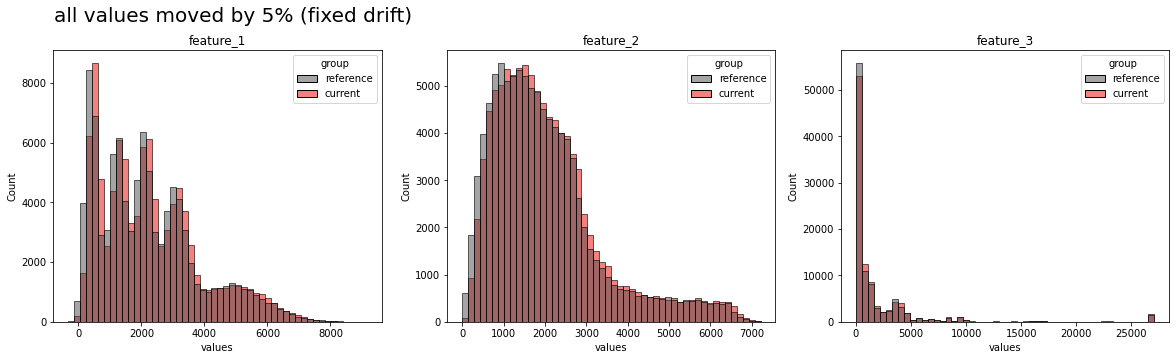

In [12]:
plot_drift(features=feature_list, drift_ratio=1, drift_size=0.05, drift_mode='fixed')

## Experiments

### KS-Test

#### Minor Shift from group size for feature 1

In [13]:
df = run_experiment(feature_1, 1, ks_stat_test.func, 0.05, sizes = [1000, 10000, 100000, 500000, 1000000], 
                    drift_ratio=1., drift_size=0.005)

In [14]:
df[['sample_size', 'mean_drift_score',	'drift_detected_ratio']]

,sample_size,mean_drift_score,drift_detected_ratio
0,1000,0.496,0.05
1,10000,0.431,0.07
2,100000,0.062,0.58
3,500000,0.0,1.0
4,1000000,0.0,1.0


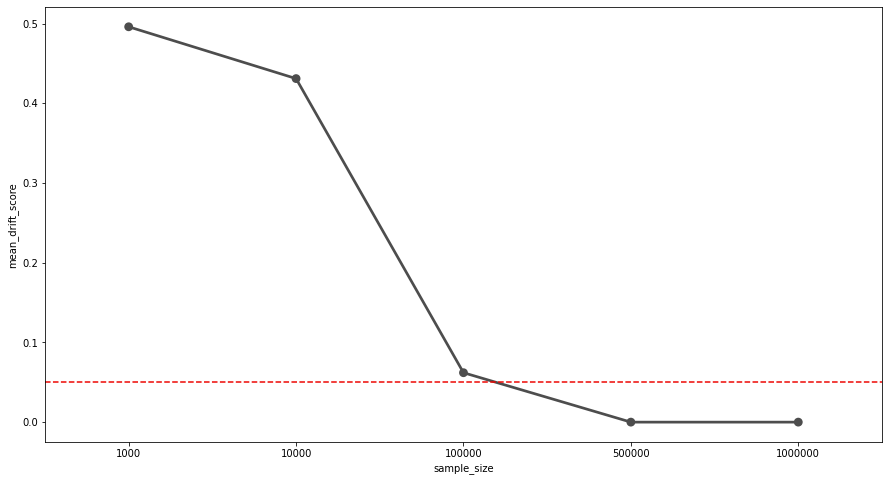

In [15]:
plt.figure(figsize=(15,8))
sns.pointplot(x='sample_size', y='mean_drift_score',  data=df, color=GREY)
plt.axhline(y=0.05, color=RED, linestyle='--');

<AxesSubplot:xlabel='sample_size', ylabel='drift_detected_ratio'>

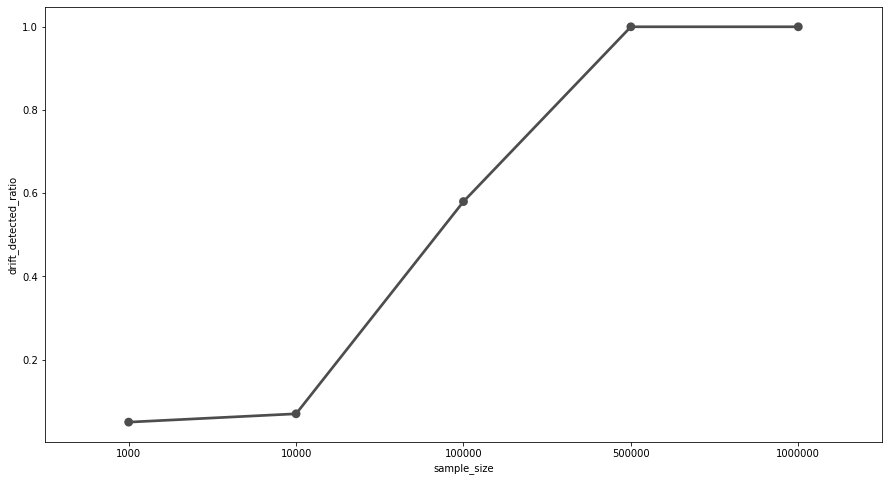

In [16]:
plt.figure(figsize=(15,8))
sns.pointplot(x='sample_size', y='drift_detected_ratio',  data=df, color=GREY)

#### Minor shift from group size for diferent features

100%|██████████| 3/3 [11:21<00:00, 227.16s/it]


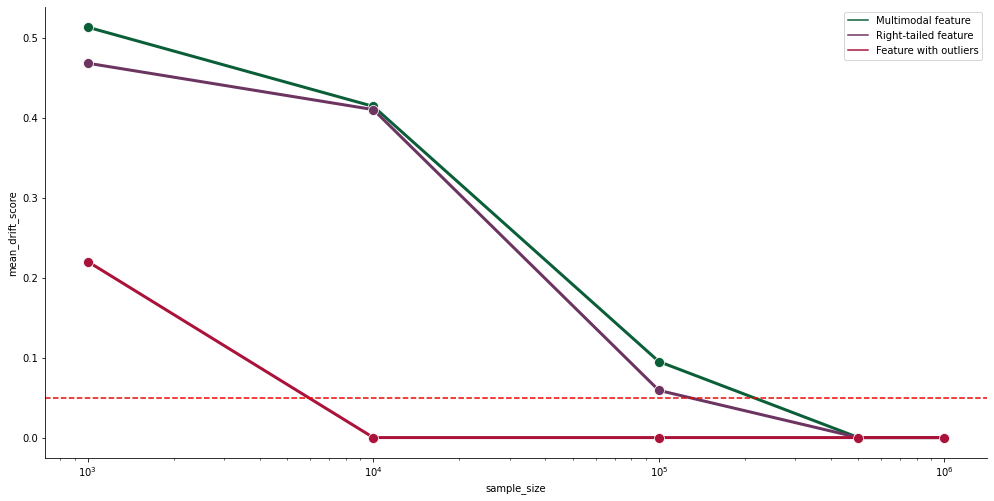

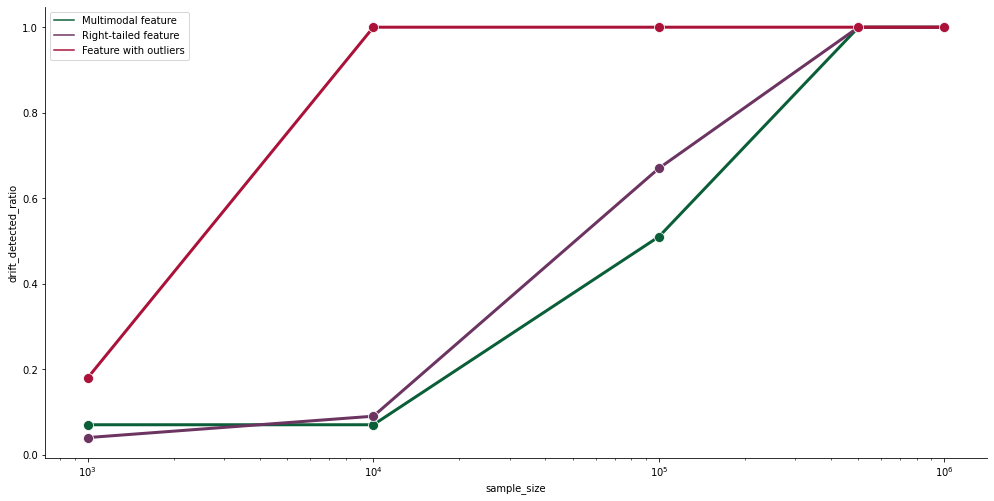

In [17]:
df = minor_shift_features(
    feature_list=feature_list, 
    feature_names=feature_names, 
    split_ratio=1, 
    get_stats=ks_stat_test.func, 
    treshold=0.05, 
    sizes=[1000, 10000, 100000, 500000, 1000000], 
    drift_ratio=1., 
    drift_size=0.005
)

#### Mean drift score from drift sizes for different features

100%|██████████| 3/3 [02:05<00:00, 41.93s/it]


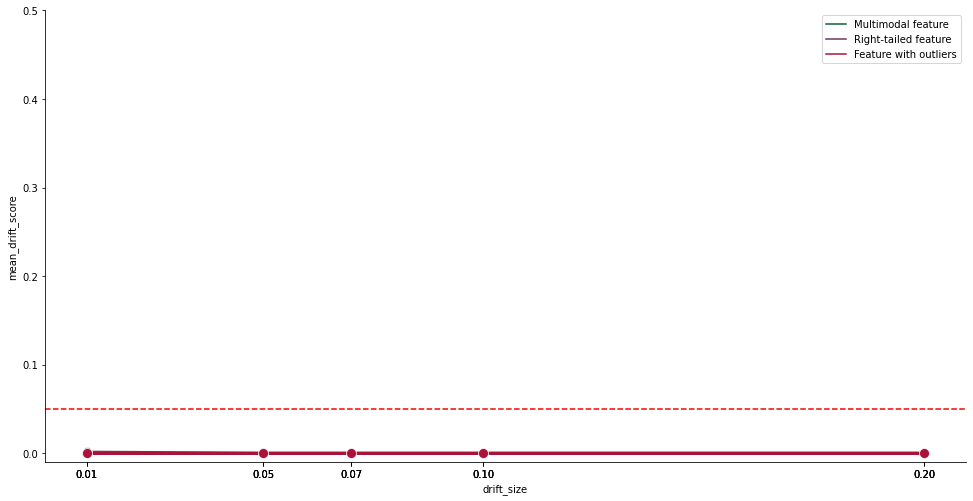

In [18]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list, 
    feature_names=feature_names, 
    split_ratio=1, 
    get_stats=ks_stat_test.func, 
    treshold=0.05, 
    sizes=[100000], 
    drift_ratio=1., 
    drift_sizes=[0.01, 0.05, 0.07, 0.1, 0.2]
)

100%|██████████| 3/3 [02:06<00:00, 42.05s/it]


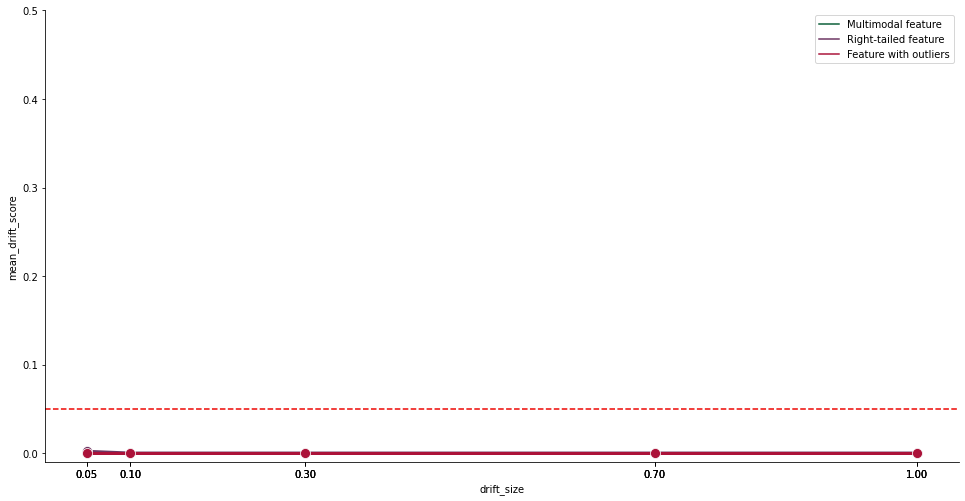

In [19]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list, 
    feature_names=feature_names, 
    split_ratio=1, 
    get_stats=ks_stat_test.func, 
    treshold=0.05, 
    sizes=[100000], 
    drift_ratio=0.2, 
    drift_sizes=[0.05, 0.1, 0.3, 0.7, 1.]
)

### PSI

#### Minor shift from group size for diferent features

100%|██████████| 3/3 [06:11<00:00, 123.98s/it]


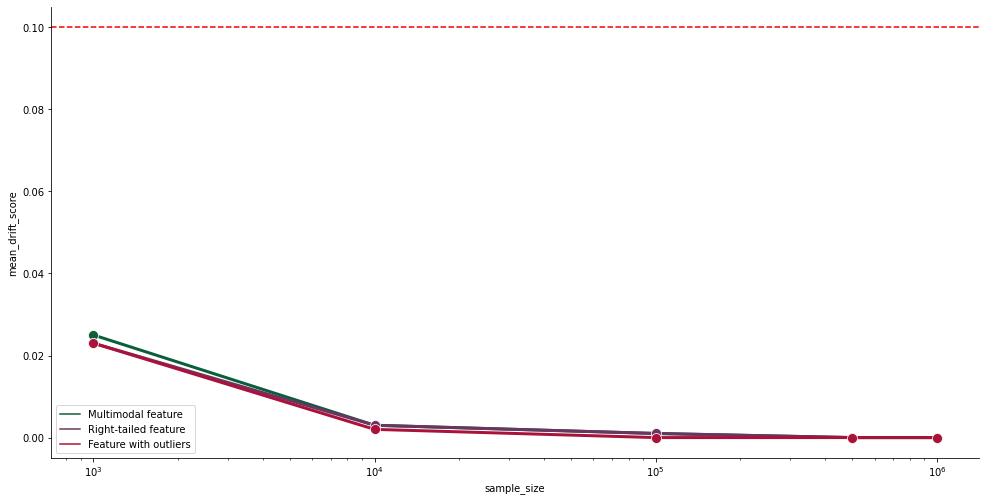

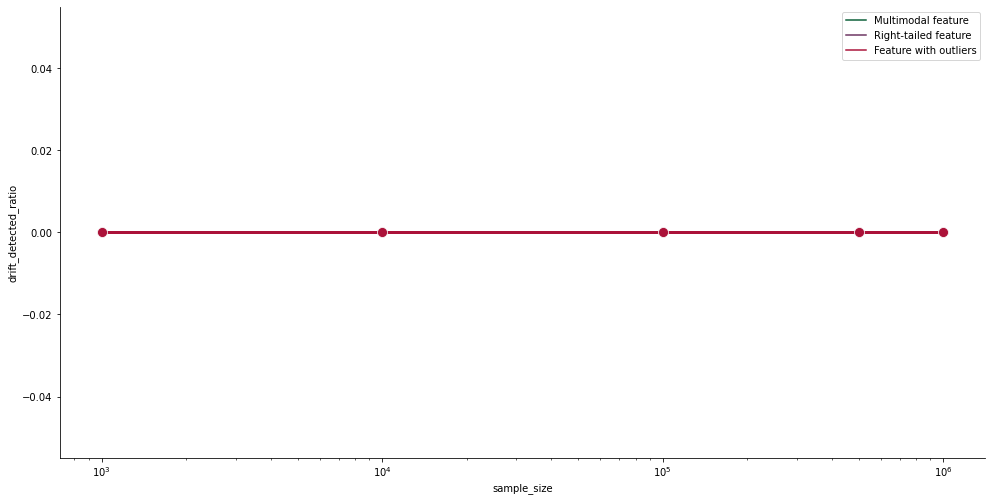

In [20]:
df = minor_shift_features(
    feature_list=feature_list, 
    feature_names=feature_names, 
    split_ratio=1, 
    get_stats=psi_stat_test.func, 
    treshold=0.1, 
    sizes=[1000, 10000, 100000, 500000, 1000000], 
    drift_ratio=1., 
    drift_size=0.005
)

#### Mean drift score from drift sizes for different features

100%|██████████| 3/3 [02:13<00:00, 44.52s/it]


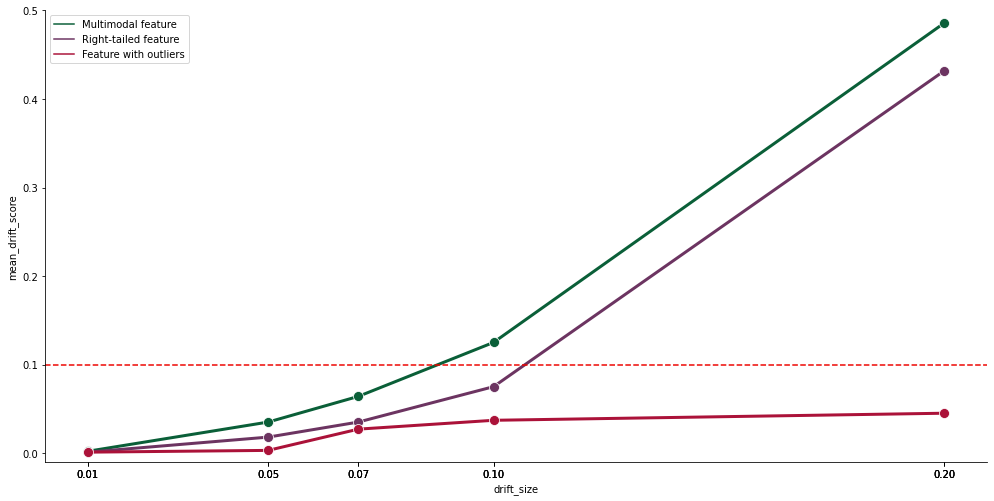

In [21]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list, 
    feature_names=feature_names, 
    split_ratio=1, 
    get_stats=psi_stat_test.func, 
    treshold=0.1, 
    sizes=[100000], 
    drift_ratio=1., 
    drift_sizes=[0.01, 0.05, 0.07, 0.1, 0.2]
)

100%|██████████| 3/3 [03:22<00:00, 67.65s/it]


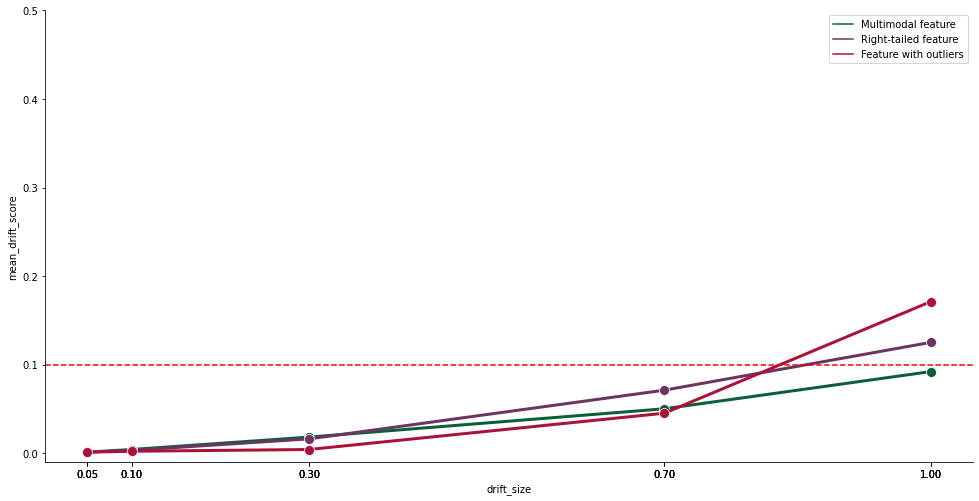

In [22]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list, 
    feature_names=feature_names, 
    split_ratio=1, 
    get_stats=psi_stat_test.func, 
    treshold=0.1, 
    sizes=[100000], 
    drift_ratio=0.2, 
    drift_sizes=[0.05, 0.1, 0.3, 0.7, 1.]
)

### KL_Div

#### Minor shift from group size for diferent features

100%|██████████| 3/3 [09:55<00:00, 198.37s/it]


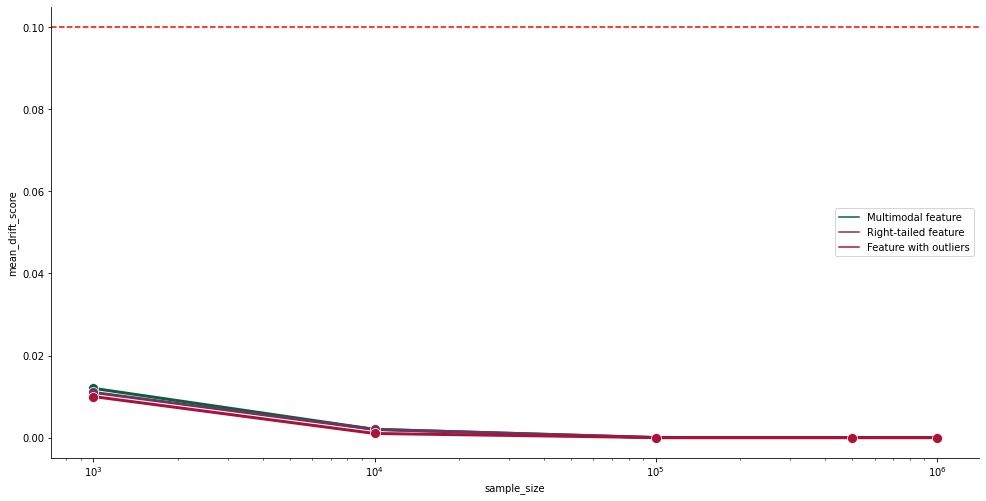

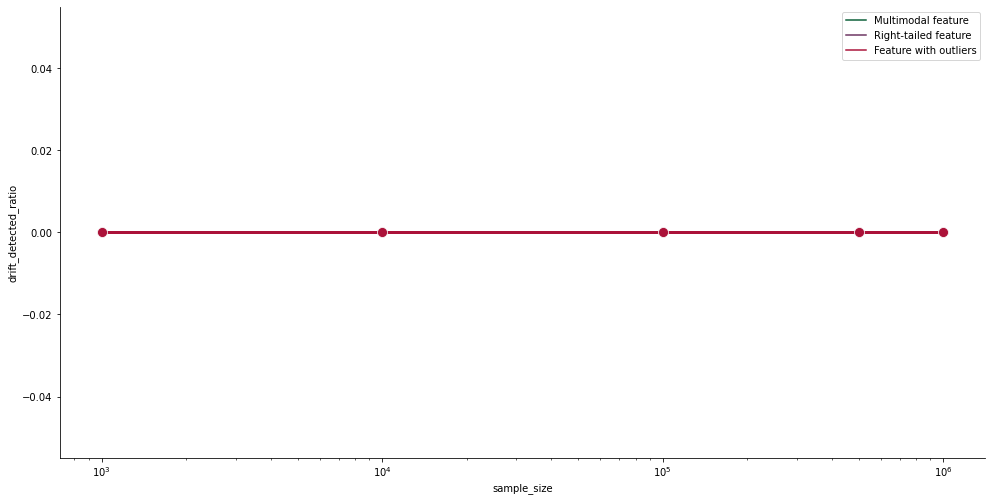

In [23]:
df = minor_shift_features(
    feature_list=feature_list, 
    feature_names=feature_names, 
    split_ratio=1, 
    get_stats=kl_div_stat_test.func, 
    treshold=0.1, 
    sizes=[1000, 10000, 100000, 500000, 1000000], 
    drift_ratio=1., 
    drift_size=0.005
)

#### Mean drift score from drift sizes for different features

100%|██████████| 3/3 [02:12<00:00, 44.16s/it]


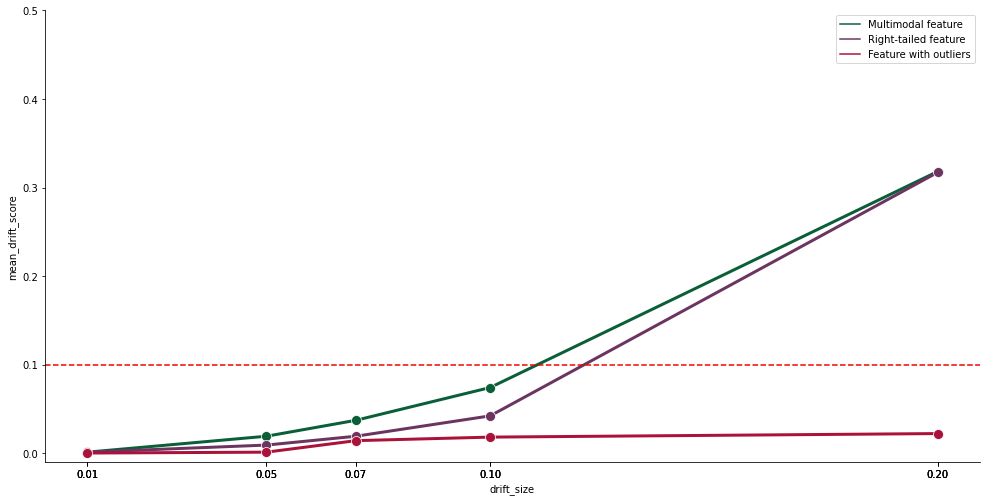

In [24]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list, 
    feature_names=feature_names, 
    split_ratio=1, 
    get_stats=kl_div_stat_test.func, 
    treshold=0.1, 
    sizes=[100000], 
    drift_ratio=1., 
    drift_sizes=[0.01, 0.05, 0.07, 0.1, 0.2]
)

100%|██████████| 3/3 [01:39<00:00, 33.20s/it]


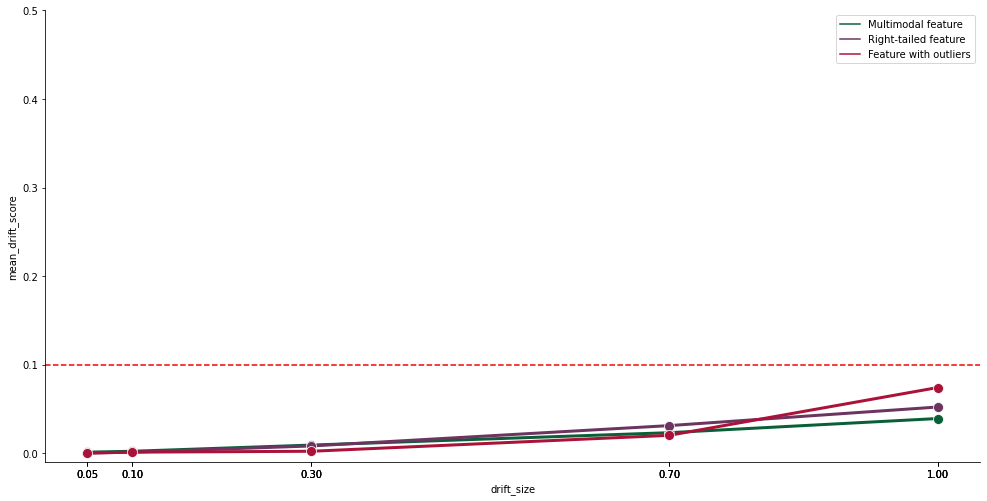

In [25]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list, 
    feature_names=feature_names, 
    split_ratio=1, 
    get_stats=kl_div_stat_test.func, 
    treshold=0.1, 
    sizes=[100000], 
    drift_ratio=0.2, 
    drift_sizes=[0.05, 0.1, 0.3, 0.7, 1.]
)

### Jensen Shannon

#### Minor shift from group size for diferent features

100%|██████████| 3/3 [07:32<00:00, 150.78s/it]


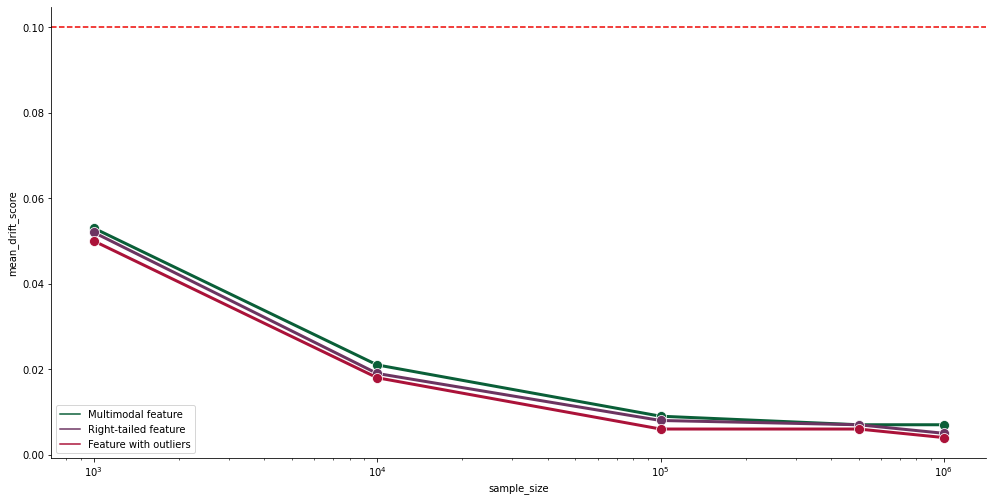

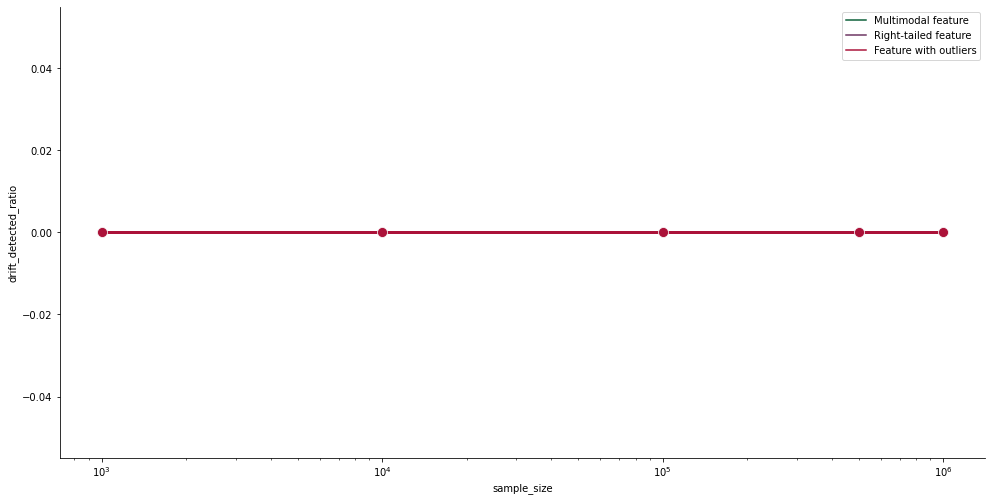

In [26]:
df = minor_shift_features(
    feature_list=feature_list, 
    feature_names=feature_names, 
    split_ratio=1, 
    get_stats=jensenshannon_stat_test.func, 
    treshold=0.1, 
    sizes=[1000, 10000, 100000, 500000, 1000000], 
    drift_ratio=1., 
    drift_size=0.005
)

#### Mean drift score from drift sizes for different features

100%|██████████| 3/3 [02:57<00:00, 59.09s/it]


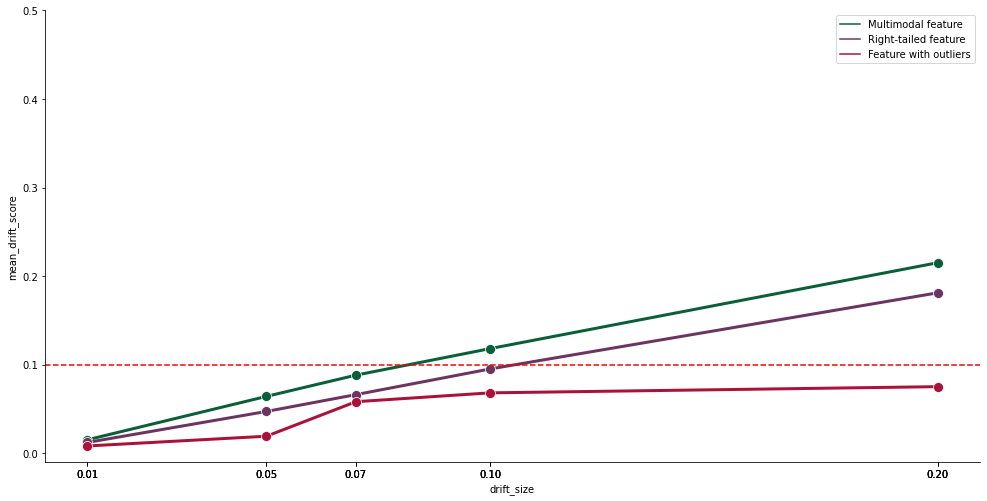

In [27]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list, 
    feature_names=feature_names, 
    split_ratio=1, 
    get_stats=jensenshannon_stat_test.func, 
    treshold=0.1, 
    sizes=[100000], 
    drift_ratio=1., 
    drift_sizes=[0.01, 0.05, 0.07, 0.1, 0.2]
)

100%|██████████| 3/3 [02:06<00:00, 42.31s/it]


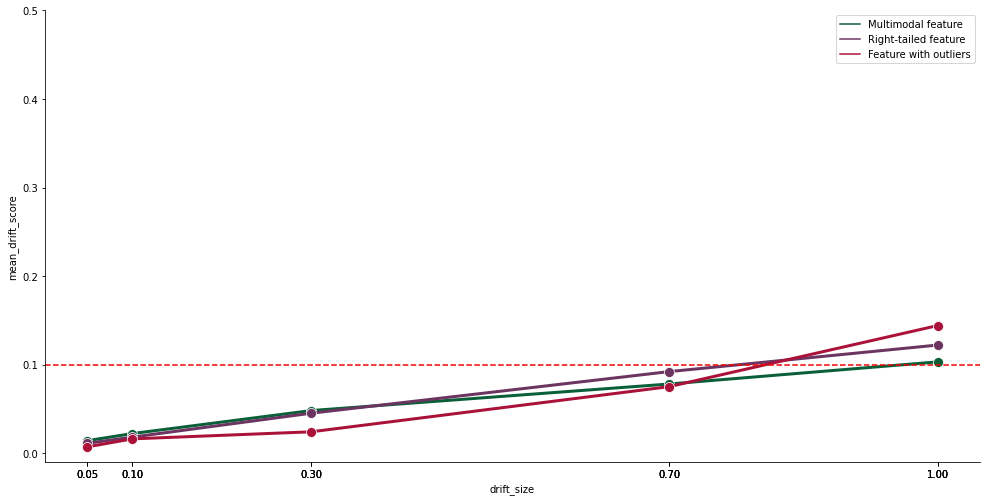

In [28]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list, 
    feature_names=feature_names, 
    split_ratio=1, 
    get_stats=jensenshannon_stat_test.func, 
    treshold=0.1, 
    sizes=[100000], 
    drift_ratio=0.2, 
    drift_sizes=[0.05, 0.1, 0.3, 0.7, 1.]
)

### Wasserstein Distance Norm

#### Minor shift from group size for diferent features

100%|██████████| 3/3 [09:17<00:00, 185.97s/it]


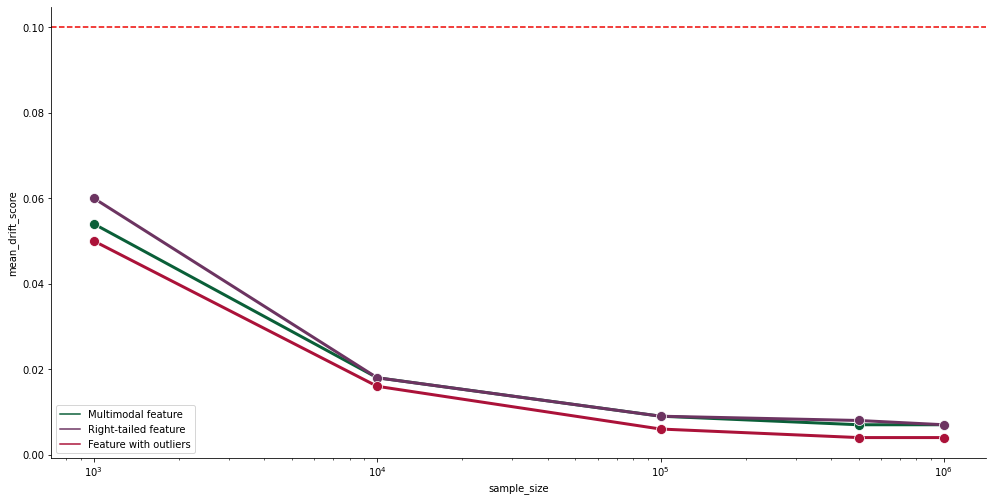

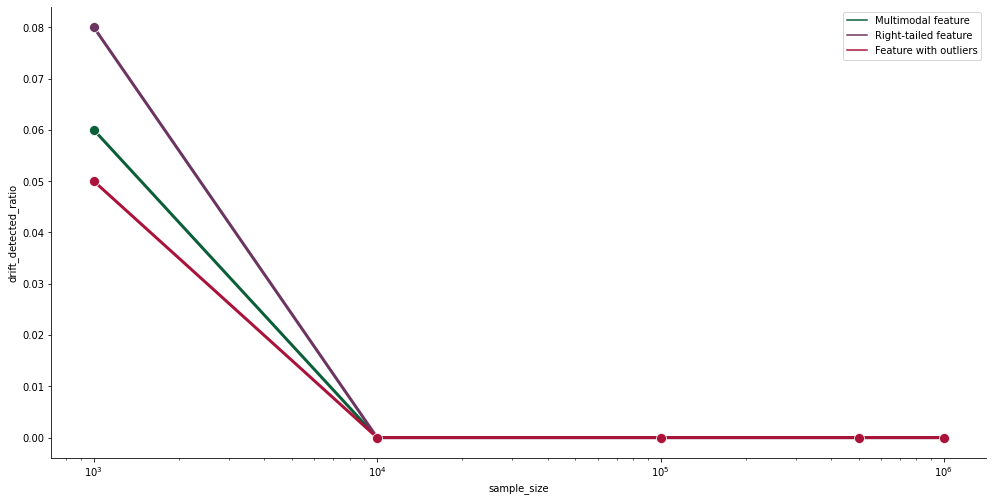

In [29]:
df = minor_shift_features(
    feature_list=feature_list, 
    feature_names=feature_names, 
    split_ratio=1, 
    get_stats=wasserstein_stat_test.func, 
    treshold=0.1, 
    sizes=[1000, 10000, 100000, 500000, 1000000], 
    drift_ratio=1., 
    drift_size=0.005
)

#### Mean drift score from drift sizes for different features

100%|██████████| 3/3 [02:02<00:00, 40.96s/it]


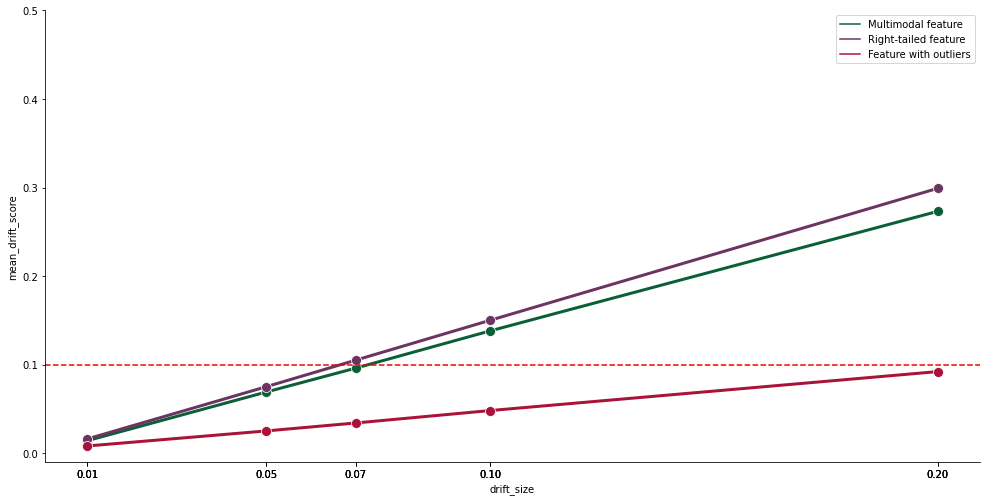

In [30]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list, 
    feature_names=feature_names, 
    split_ratio=1, 
    get_stats=wasserstein_stat_test.func, 
    treshold=0.1, 
    sizes=[100000], 
    drift_ratio=1., 
    drift_sizes=[0.01, 0.05, 0.07, 0.1, 0.2]
)

100%|██████████| 3/3 [01:57<00:00, 39.02s/it]


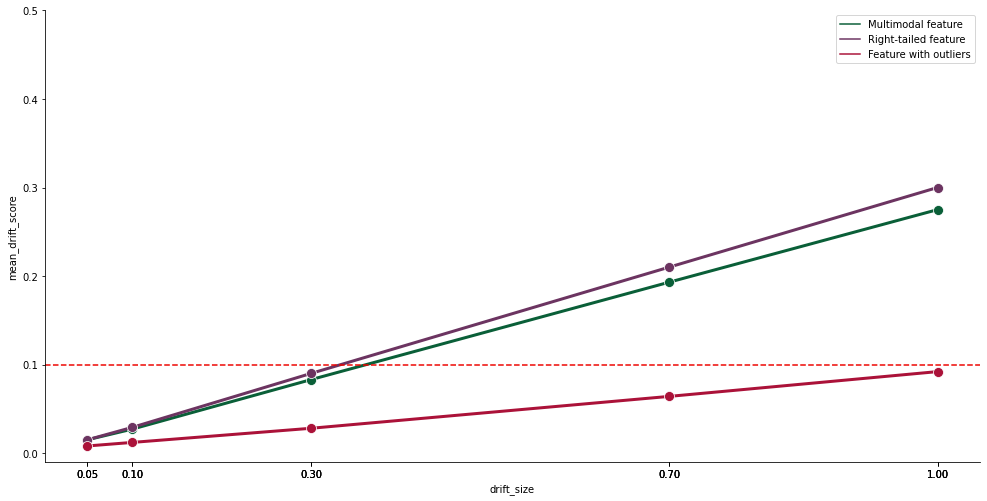

In [31]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list, 
    feature_names=feature_names, 
    split_ratio=1, 
    get_stats=wasserstein_stat_test.func, 
    treshold=0.1, 
    sizes=[100000], 
    drift_ratio=0.2, 
    drift_sizes=[0.05, 0.1, 0.3, 0.7, 1.]
)

## Time Series (Historical Changes)

In [1]:
from evidently.analyzers.stattests.jensenshannon import jensenshannon_stat_test
from evidently.analyzers.stattests.kl_div import kl_div_stat_test
from evidently.analyzers.stattests.ks_stattest import ks_stat_test
from evidently.analyzers.stattests.psi import psi_stat_test
from evidently.analyzers.stattests.wasserstein_distance_norm import wasserstein_stat_test

In [3]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import numpy as np

def plot_example(ref: pd.Series, curr: pd.Series):
  fig = plt.figure(constrained_layout=True, figsize=(15,7))

  gs = GridSpec(2, 3, figure=fig)
  ax1 = fig.add_subplot(gs[0, :])
  ax2 = fig.add_subplot(gs[1, 0])
  ax3 = fig.add_subplot(gs[1, 1])
  ax4 = fig.add_subplot(gs[1, 2])

  # plot feature in time
  ref_points = int(np.round(150 * len(ref) /(len(ref) + len(curr))))
  curr_points = 150 - ref_points

  ref_in_time = [np.mean(x) for x in np.array_split(ref, ref_points)]
  curr_in_time = [np.mean(x) for x in np.array_split(curr, curr_points)]

  ax1.plot(range(ref_points), ref_in_time, color=GREY)
  ax1.plot(range(ref_points, ref_points + curr_points), curr_in_time, color=RED)

  # plot referense distr
  sns.histplot(ref, color=GREY, ax=ax2)
  # plot current distr
  sns.histplot(curr, color=RED, ax=ax3)
  # plot two distr
  sns.histplot(ref, color=GREY, ax=ax4)
  sns.histplot(curr, color=RED, ax=ax4)
  plt.show()

def evaluare_drift(ref: pd.Series, curr: pd.Series):
  report = pd.DataFrame(columns=['stat_test', 'drift_score', 'is_drifted'])
  for i, (stattest, threshold) in enumerate(
      zip(
          [ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test],
          [0.05, 0.1, 0.1, 0.1, 0.1]
      )
  ):
    report.loc[i, 'stat_test'] = stattest.display_name
    report.loc[i, 'drift_score'], report.loc[i, 'is_drifted'] = stattest.func(ref, curr, 'num', threshold)
  return report

Let's assume this is historical data with no drift

In [4]:
from sklearn.datasets import fetch_california_housing
df = fetch_california_housing(as_frame=True).frame
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [5]:
ref = df.MedInc[:10000]
curr = df.MedInc[10000:]

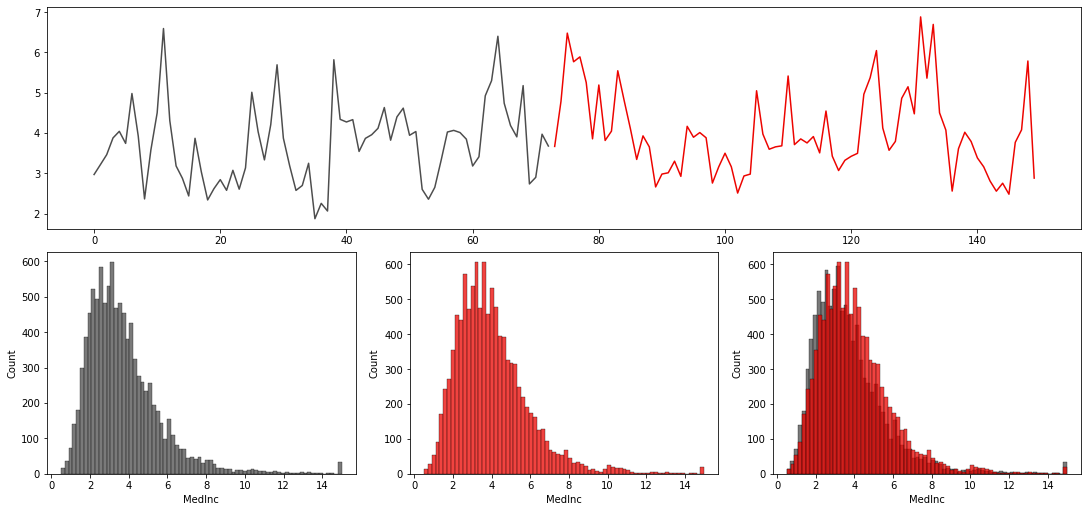

,stat_test,drift_score,is_drifted
0,K-S p_value,0.0,True
1,PSI,0.048094,False
2,Kullback-Leibler divergence,0.024445,False
3,Jensen-Shannon distance,0.077359,False
4,Wasserstein distance (normed),0.164027,True


In [9]:
# get resuts
plot_example(ref, curr)
evaluare_drift(ref, curr)

If you don’t have cases of data drift in historical data, you can imitate it. You can use this function:

In [10]:
def add_drift(curr: pd.Series, drift_size: float, drift_ratio: float, drift_mode: str='fixed') -> pd.Series:
  """Artificially adds a shift to the data.
  Args:
    curr: initial data
    drift_size: percents initial values would be increased by
    drift_ratio: defines what percent of data would be drifted
    drift_mode:
      if drift_mode == 'fixed': 
        # here we should use mean(reference), but in out experiment mean(reference) = mean(current) at this stage
        all values moved by fixed delta = (alpha + mean(feature)) * drift_size
      elif: 
        drift_mode == 'relative': vlues moved by delta(value) = value * drift_size
  Returns:
    curr: drifted data
  """
  alpha = 0.001
  i = int(np.round(len(curr) * drift_ratio))
  if drift_mode == 'fixed':
    delta = (alpha + np.mean(curr)) * drift_size
    curr[:i] = curr[:i] + delta
  else:
    curr[:i] = curr[:i]*(1 + drift_size)
  return curr

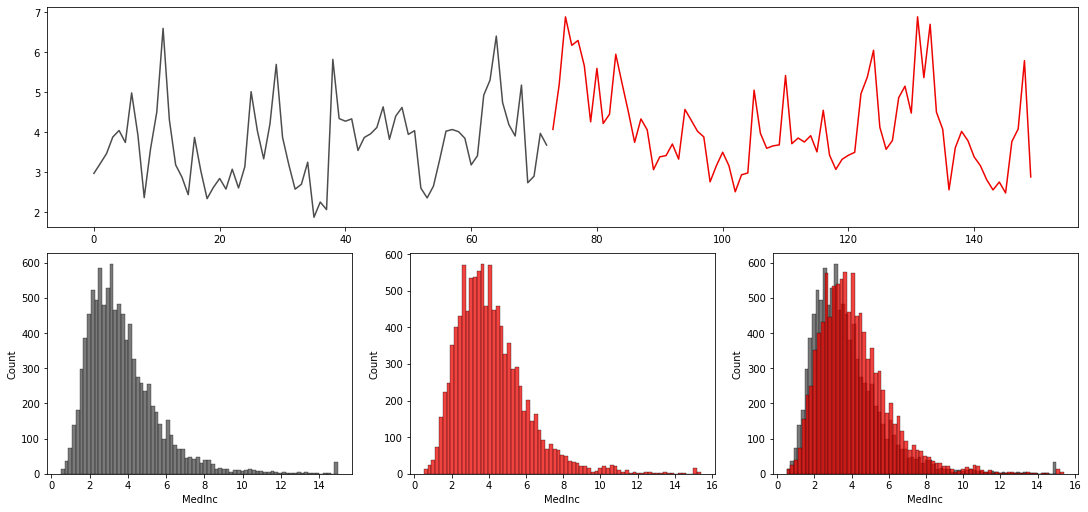

,stat_test,drift_score,is_drifted
0,K-S p_value,0.0,True
1,PSI,0.085883,False
2,Kullback-Leibler divergence,0.043889,False
3,Jensen-Shannon distance,0.103237,True
4,Wasserstein distance (normed),0.225225,True


In [11]:
curr_shifted = add_drift(curr, drift_size=0.1, drift_ratio=0.3, drift_mode='fixed')

plot_example(ref, curr_shifted)
evaluare_drift(ref, curr_shifted)

or you can model drift in some other way, depending on the knowledge of the subject area

for example, you can move only a segment of data referring to old houses

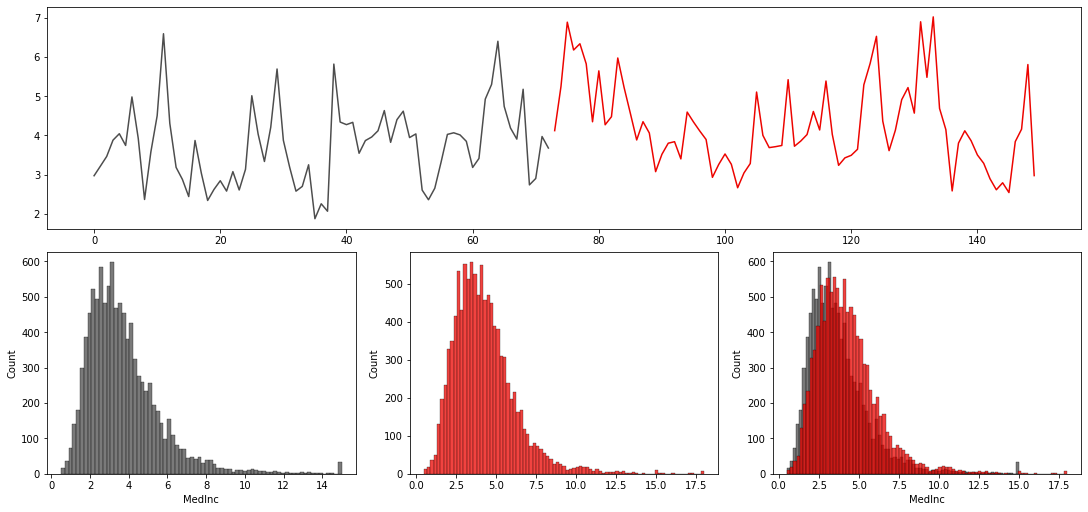

,stat_test,drift_score,is_drifted
0,K-S p_value,0.0,True
1,PSI,0.128155,True
2,Kullback-Leibler divergence,0.065418,False
3,Jensen-Shannon distance,0.126385,True
4,Wasserstein distance (normed),0.290952,True


In [12]:
ref = df.MedInc[:10000]
curr = df.MedInc[10000:]

curr_shifted = curr*(1 + (df[10000:].HouseAge>=37).astype(int)*0.2)

plot_example(ref, curr_shifted)
evaluare_drift(ref, curr_shifted)